# Easy 21

In this project, we implement reinforcement learning algorithms for a simple game called _easy21_. It is a simplified version of the _Blackjack_ game popularly seen in the casinos. The rules of the game are as follows:
<ol>
    <li>Game is played with infinite deck of cards.</li>
    <li>Each card draw has a value (1 to 10, uniformly distributed; no face cards) and a color (1/3 probability red and 2/3 probability black)</li>
    <li>At the start of game, player and dealder each draw one _black_ card (fully observed).</li>
    <li>Player makes move first and can either _stick_(draw one card according to the rules described) or _hit_(receives no further card).</li>
    <li>The value of the player's cards are added for black ones and subtracted for red ones.</li>
    <li>If the player's sum goes above 21 or falls below 0, the game immediately terminates and the player goes bust and gets a reward of -1.</li>
    <li>If the player sticks without going bust, the dealer takes turn and plays the game. The dealer always sticks when his own sum is between 17 and 21, and hits otherwise. If dealer goes bust or sticks with a lower sum, player gets reward 1. If dealer sticks with a higher sum and does not go bust, player gets -1. If they have the same sum, the reward is 0. </li>
<ol>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

First we implement the game environment as a function _step_(_d_,_s_,_a_) which takes in the dealder card _d_, current player sum _s_, action _a_ and generate as outputs the new state and reward.

In [2]:
def card_draw(first=False):
    value = random.randint(1, 10)
    color = random.randint(1, 3)
    card = value if color > 1 or first is True else -value
    return card

def step(d, s, a):
    
    # d = dealer card; s = current sum; a = action (0 = stick, 1 = hit)
    if a == 0:       
        
        # stick;
        s_new = s
        
        # dealer playout
        s_dealer = d
        while s_dealer < 17 and s_dealer > 0:
            s_dealer += card_draw()
            
        if s_dealer > 21 or s_dealer < 1:
            # dealer goes bust
            r = 1
        else:
            # compare sum to determine payout
            if s_dealer > s:
                r = -1
            elif s_dealer < s:
                r = 1
            else:
                r = 0
                
#         print('dealer sum %d'%s_dealer)
        
    elif a == 1:
        
        # hit
        s_new = s + card_draw()
        r = -1 if s_new > 21 or s_new < 1 else 0
    
    return s_new, r

# test drawing cards
print('game 1')
d, s = card_draw(True), card_draw(True)
print('dealer card %d, player card %d'%(d, s))
print('player sticks')
s, r = step(d, s, a=0)
print('player sum %d, reward %d'%(s, r))

print('\ngame 2')
d, s = card_draw(True), card_draw(True)
print('dealer card %d, player card %d'%(d, s))
print('player hits')
s, r = step(d, s, a=1)
print('player sum %d, reward %d'%(s, r))
print('player hits')
s, r = step(d, s, a=1)
print('player sum %d, reward %d'%(s, r))

game 1
dealer card 4, player card 8
player sticks
player sum 8, reward 1

game 2
dealer card 7, player card 6
player hits
player sum 5, reward 0
player hits
player sum 2, reward 0


## Monte Carlo control
First we apply Monte Carlo control for model-free reinforcement learning.

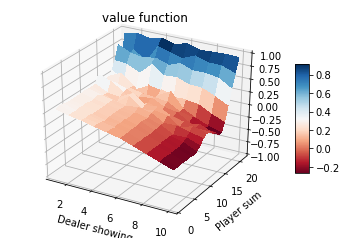

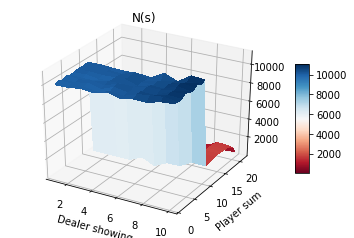

In [3]:
Q = np.zeros((10, 21, 2))
Nsa = np.zeros((10, 21, 2))     # number of times action has been selected from state s
N0 = 100
num_eps = int(1e6)              # number of episodes


def ep_greedy(d, s, Q, Ns):
    
    # an epsilon-greedy strategy where ep = N0/(N0+N(s))
    # assume 1<=d<=10 and 1<=s<=21
    ep = N0/(N0 + Ns[d-1, s-1])
    if random.random() < ep:
        # exploration
        action = random.randint(0, 1)
    else:
        # exploitation
        action = np.argmax(Q[d-1, s-1, :])
        
    return action


# main episodic iteration
for _ in range(num_eps):
    
    # set initial state
    episode = list()
    d, s = card_draw(first=True), card_draw(first=True)
    end = False
    
    # generate episode
    while end is False:
        a = ep_greedy(d, s, Q, np.sum(Nsa, axis=-1))
        s_new, r = step(d, s, a)
        end = True if a == 0 or s_new > 21 or s_new < 1 else False
        episode.append([d, s, a])
        s = s_new
        
#     # print episode (for testing only)
#     print('Episode summary: dealer card %d'%d)
#     for p in episode:
#         print('player sum %d, action %d'%(p[1], p[2]))
#     print('final reward %d'%r)

    # incrementally update value functions
    for p in episode:
        Nsa[p[0]-1, p[1]-1, p[2]] += 1
        alpha = 1/Nsa[p[0]-1, p[1]-1, p[2]]
        Q[p[0]-1, p[1]-1, p[2]] += alpha*(r - Q[p[0]-1, p[1]-1, p[2]])

# plot final value function
V = np.amax(Q, axis=-1)

fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = np.meshgrid(np.arange(1, 11), np.arange(1, 22))
surf = ax.plot_surface(x1, x2, V.T, cmap='RdBu', linewidth=0, antialiased=False)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlim([-1, 1])
ax.set_title('value function')
fig.colorbar(surf, shrink=0.5, aspect=8)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, np.sum(Nsa, axis=-1).T, cmap='RdBu', linewidth=0, antialiased=False)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_title('N(s)')
fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

In [4]:
print('Optimal policy:')
print(np.argmax(Q, axis=-1))

np.set_printoptions(precision=2, suppress=True)
print('\nOptimal action value:')
print(V)

Optimal policy:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0]]

Optimal action value:
[[ 0.32  0.34  0.33  0.31  0.3   0.31  0.31  0.31  0.32  0.31  0.31  0.32
   0.46  0.2   0.23  0.3   0.38  0.56  0.8   0.5   0.94]
 [ 0.26  0.26  0.25  0.26  0.25  0.27  0.24  0.25  0.28  0.24  0.2   0.2
   0.38  0.33  0.19  0.42  0.22  0.53  0.69  0.71  1.  ]
 [ 0.22  0.2   0.22  0.2   0.2   0.2   0.19  0.21  0.2   0.19  0.11  0.17
   0.22  0.24  0.22  0.22  0.13  0.42  0.65  0.53  0.95]
 [ 0.16  0.16  0.15  0.12  0.14  0.16  0.15  0.15  0.14  0.14  0.29  0.3
   0.    0.13  0.17 -0.06  0.26  0.64  0.7   

## Temporal Difference
In the following we implement the sarsa($\lambda$) algorithm for reinforcement learning.

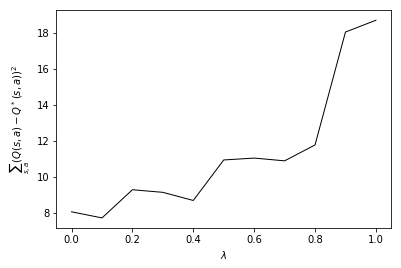

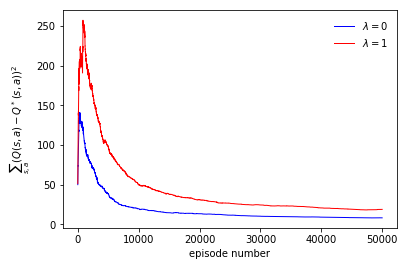

In [30]:
num_eps = int(5e4)    # number of episodes
lmdas = np.linspace(0, 1, 11)
Q_ss = np.zeros((len(lmdas), 10, 21))    # stores final optimal action values for all lambdas
errs = np.zeros((len(lmdas), num_eps))

for idx, lmda in enumerate(lmdas):
    
    Q_s = np.zeros((10, 21, 2))
    Nsa_s = np.zeros((10, 21, 2))    # number of times action has been selected from state s

    # main episodic iteration
    for eps in range(num_eps):
    
        # set initial state
        E = np.zeros((10, 21, 2))    # eligibility trace
        d, s = card_draw(first=True), card_draw(first=True)    # initialize state
        a = ep_greedy(d, s, Q_s, np.sum(Nsa_s, axis=-1))    # initialize action
        end = False
    
        # episode stepping
        while end is False:
            
            s_new, r = step(d, s, a)
            end = True if a == 0 or s_new > 21 or s_new < 1 else False
            
            # rewards are associated with terminal states, not actions
            if end is False:
                a_next = ep_greedy(d, s_new, Q_s, np.sum(Nsa_s, axis=-1))
                delta = Q_s[d-1, s_new-1, a_next] - Q_s[d-1, s-1, a]
            else:
                delta = r - Q_s[d-1, s-1, a]
            
            E[d-1, s-1, a] += 1
            Nsa_s[d-1, s-1, a] += 1
            alpha = 1/Nsa_s[d-1, s-1, a]
            Q_s = Q_s + alpha * delta * E
            E = lmda*E
            
            s, a = s_new, a_next
    
        # calculate error
        errs[idx, eps] = np.sum((Q_s - Q)**2)
        
    # store final optimal action value
    Q_ss[idx] = np.amax(Q_s, axis=-1)

# plot err vs. lambda
plt.figure()
plt.plot(lmdas, errs[:, -1], 'k-', linewidth=1)
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\sum_{s,a}(Q(s,a) - Q^*(s,a))^2$')

# plot learning curve for lambda = 0 and 1
plt.figure()
plt.plot(np.arange(num_eps), errs[0, :], 'b-', label=r'$\lambda=0$', linewidth=1)
plt.plot(np.arange(num_eps), errs[-1, :], 'r-', label=r'$\lambda=1$', linewidth=1)
plt.xlabel('episode number')
plt.ylabel(r'$\sum_{s,a}(Q(s,a) - Q^*(s,a))^2$')
plt.legend(frameon=False)

plt.show()

Now we plot the value function for $\lambda = 0$

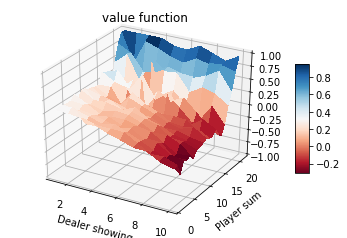

In [31]:
# plot value function
fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = np.meshgrid(np.arange(1, 11), np.arange(1, 22))
surf = ax.plot_surface(x1, x2, Q_ss[0].T, cmap='RdBu', linewidth=0, antialiased=False)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Player sum')
ax.set_zlim([-1, 1])
ax.set_title('value function')
fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

which is essentially the same result from Monte Carlo control. But with sarsa($\lambda$) convergence happens much more quickly.